## US Accidents Integration
### Goal: For each intersection, generate a list of nearby accidents
For initial research we will work only in DC

In [76]:
from dot import osm
import geopandas as gpd
from geopy.distance import distance
import osmnx as ox
import pandas as pd
from scipy.special import softmax
from tqdm import tqdm

pd.set_option('display.max_columns', None)

### Read the US Accidents dataset

In [2]:
us_acc_df = pd.read_csv('../data/US_Accidents_June20.tar.gz', low_memory=False)
dc_acc_df = us_acc_df[us_acc_df['State']=='DC']
dc_acc_df.head()

,US_Accidents_June20.csv,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
228625,A-228627,MapQuest,201.0,2.0,2016-11-30 20:35:42,2016-11-30 21:05:21,38.888493,-77.052330,NaN,NaN,0.01,Accident on Lincoln Memorial Cir near Ohio Dr.,NaN,Ohio Dr SW,R,Washington,District of Columbia,DC,20024,US,US/Eastern,KDCA,2016-11-30 20:52:00,59.0,NaN,93.0,29.60,10.0,NE,8.1,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
228645,A-228647,MapQuest,201.0,2.0,2016-12-01 05:29:50,2016-12-01 06:16:06,38.902523,-77.009048,NaN,NaN,0.01,Right lane blocked due to accident on Capitol ...,999.0,N Capitol St NE,L,Washington,District Of Columbia,DC,20002-4684,US,US/Eastern,KDCA,2016-12-01 05:52:00,54.0,NaN,62.0,29.71,10.0,Calm,NaN,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night
228649,A-228651,MapQuest,203.0,2.0,2016-12-01 06:03:47,2016-12-01 06:48:16,38.902363,-76.943741,NaN,NaN,0.01,Two left lane closed due to multi-vehicle acci...,4073.0,Nannie Helen Burroughs Ave NE,L,Washington,District of Columbia,DC,20019,US,US/Eastern,KWBC,2016-12-01 06:19:00,NaN,NaN,NaN,NaN,NaN,North,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Day
228653,A-228655,MapQuest,201.0,2.0,2016-12-01 06:20:45,2016-12-01 07:04:52,38.882065,-77.027855,NaN,NaN,0.01,Right lane closed due to accident on Southwest...,NaN,12th St SW,R,Washington,District of Columbia,DC,20024,US,US/Eastern,KDCA,2016-12-01 05:52:00,54.0,NaN,62.0,29.71,10.0,Calm,NaN,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
228685,A-228687,MapQuest,201.0,2.0,2016-12-01 07:32:10,2016-12-01 08:16:08,38.961742,-77.042847,NaN,NaN,0.01,Left lane closed due to accident on Military R...,NaN,Military Rd NW,R,Washington,District of Columbia,DC,20012,US,US/Eastern,KCGS,2016-12-01 07:27:00,50.0,NaN,58.0,29.74,10.0,WNW,6.9,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [114]:
dc_acc_df.Severity.describe()

count    4820.000000
mean        2.504149
std         0.743641
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Severity, dtype: float64

### Load the intersections from OpenStreetMap

In [3]:
dc_map = osm.get_graph_from_place('Washington DC')

In [4]:
try:
    dc_map = ox.simplify_graph(dc_map.copy(), strict=False)
except Exception:
    pass
dc_intrs_list = osm.graph_to_nodes(dc_map)

In [108]:
dc_intrs_list = osm.graph_to_nodes(dc_map)
dc_intrs_list[:5]

[(281074,
  {'y': 38.9366631,
   'x': -77.1082541,
   'osmid': 281074,
   'type': 0,
   'angles': None,
   'roadways': []}),
 (29918140,
  {'y': 38.9651003,
   'x': -77.0471434,
   'osmid': 29918140,
   'type': <JunctionType.PEDESTRIAN|ROADWAY: 5>,
   'angles': None,
   'roadways': ['Beach Drive Northwest']}),
 (30066940,
  {'y': 38.8842085,
   'x': -77.0034402,
   'osmid': 30066940,
   'type': <JunctionType.OTHER: 32>,
   'angles': None,
   'roadways': []}),
 (30066941,
  {'y': 38.8833257,
   'x': -77.003434,
   'osmid': 30066941,
   'type': <JunctionType.OTHER: 32>,
   'angles': None,
   'roadways': []}),
 (30066942,
  {'y': 38.8833246,
   'x': -77.0021464,
   'osmid': 30066942,
   'type': <JunctionType.OTHER: 32>,
   'angles': None,
   'roadways': []})]

In [5]:
for intersection in dc_intrs_list:
    intersection[1]['type'] = osm.extract_intersection_type(dc_map, intersection[0])
    intersection[1]['angles'] = osm.extract_intersection_angles(dc_map, intersection[0])
    intersection[1]['roadways'] = osm.extract_intersection_roadway_names(dc_map, intersection[0])
    
dc_intrs_df = pd.DataFrame([i[1] for i in dc_intrs_list])
dc_intrs_df.head()

,y,x,osmid,type,angles,roadways,highway,ref
0,38.936663,-77.108254,281074,0,None,[],NaN,NaN
1,38.965100,-77.047143,29918140,5,None,[Beach Drive Northwest],NaN,NaN
2,38.884208,-77.003440,30066940,32,None,[],NaN,NaN
3,38.883326,-77.003434,30066941,32,None,[],NaN,NaN
4,38.883325,-77.002146,30066942,32,None,[],NaN,NaN


### Create GeoPandas DataFrames

In [22]:
# Resource: https://gis.stackexchange.com/questions/349637/given-list-of-points-lat-long-how-to-find-all-points-within-radius-of-a-give
# crs argument is to set the Coordinate Reference System
# EPSG:4326 is the WGS84 latitude-longitude projection, units in degrees
dc_intrs_gdf = gpd.GeoDataFrame(dc_intrs_df, geometry=gpd.points_from_xy(dc_intrs_df.x, dc_intrs_df.y), crs={"init":"EPSG:4326"})
dc_acc_gdf = gpd.GeoDataFrame(dc_acc_df, geometry=gpd.points_from_xy(dc_acc_df.Start_Lng, dc_acc_df.Start_Lat), crs={"init":"EPSG:4326"})

/Users/davidwaterman/.virtualenvs/dot-road-safety/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Create Projections to measure distances in meters

In [23]:
# EPSG:3857 is WGS 84 / Pseudo-Mercator -- Spherical Mercator, Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI
# Ellipsoidal distance model! Units in meters
dc_intrs_gdf_proj = dc_intrs_gdf.to_crs({"init": "EPSG:3857"})
dc_acc_gdf_proj = dc_acc_gdf.to_crs({"init": "EPSG:3857"})

### Sample one intersection and find all accidents within 200 meters

In [27]:
# Choose 200 meters for initial measure of "nearby" 
intr_sample = dc_intrs_gdf_proj.iloc[8:9]
x = intr_sample.buffer(200).unary_union

neighbours = dc_acc_gdf_proj["geometry"].intersection(x)

# print all the nearby accident IDs
print(dc_acc_gdf_proj[~neighbours.is_empty])

        US_Accidents_June20.csv    Source    TMC  Severity  \
239440                 A-239442  MapQuest  201.0       2.0   
518146                 A-518152  MapQuest  241.0       2.0   
979210                 A-979236  MapQuest  201.0       2.0   
988469                 A-988495  MapQuest  201.0       2.0   
2178437               A-2178477  MapQuest  201.0       2.0   
2561874               A-2561915      Bing    NaN       4.0   
2719460               A-2719501      Bing    NaN       2.0   
2726544               A-2726585      Bing    NaN       4.0   
2726556               A-2726597      Bing    NaN       4.0   
2726559               A-2726600      Bing    NaN       4.0   
2913629               A-2913670      Bing    NaN       2.0   
2913638               A-2913679      Bing    NaN       2.0   
2913650               A-2913691      Bing    NaN       2.0   
2913653               A-2913694      Bing    NaN       2.0   
2913663               A-2913704      Bing    NaN       2.0   
3185979 

### Find the distance from each accident to the intersection

In [53]:
distances = []
for idx, row in dc_acc_gdf_proj[~neighbours.is_empty].iterrows():
    crash_dist = distance((intr_sample.y.values[0], intr_sample.x.values[0]), (row.Start_Lat, row.Start_Lng))
    print(f"Distance to accident {idx}: {crash_dist.m} meters")
    distances.append(crash_dist.m)
    

# Does the same as above without adding geopy as a dependency
# from shapely.geometry import Point
# geom = [Point(intr_sample.x, intr_sample.y), Point(row.Start_Lng, row.Start_Lat)]
# gdf = gpd.GeoDataFrame(geometry=geom, crs={'init':'epsg:4326'})
# gdf.to_crs(epsg=3857, inplace=True)
# l = gdf.distance(gdf.shift())
# print(l)

Distance to accident 239440: 147.87148024509398 meters
Distance to accident 518146: 116.8496056645313 meters
Distance to accident 979210: 149.64859251418738 meters
Distance to accident 988469: 128.05487221582356 meters
Distance to accident 2178437: 147.87148024509398 meters
Distance to accident 2561874: 149.64891887769392 meters
Distance to accident 2719460: 149.64891887769392 meters
Distance to accident 2726544: 115.7489186616088 meters
Distance to accident 2726556: 115.7489186616088 meters
Distance to accident 2726559: 115.7489186616088 meters
Distance to accident 2913629: 149.64891887769392 meters
Distance to accident 2913638: 149.64891887769392 meters
Distance to accident 2913650: 149.64891887769392 meters
Distance to accident 2913653: 149.64891887769392 meters
Distance to accident 2913663: 149.64891887769392 meters
Distance to accident 3185979: 149.64891887769392 meters
Distance to accident 3201908: 149.64891887769392 meters


### Weight the accidents by taking the softmin of the distances

In [57]:
softmax([-i for i in distances])

array([3.36170379e-15, 9.98132951e-02, 5.68550953e-16, 1.35769732e-06,
       3.36170379e-15, 5.68365429e-16, 5.68365429e-16, 3.00061782e-01,
       3.00061782e-01, 3.00061782e-01, 5.68365429e-16, 5.68365429e-16,
       5.68365429e-16, 5.68365429e-16, 5.68365429e-16, 5.68365429e-16,
       5.68365429e-16])

### Put it all together to create a list of [{'accident': id, 'weight': softmin} , ...] for each intersection

In [100]:
new_intrs_list = []
for idx, row in tqdm(dc_intrs_gdf_proj.head(10000).iterrows(), total=dc_intrs_gdf.head(10000).shape[0]):
    # make row into GPD df
    df = row.to_frame().T
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs={"init":"EPSG:4326"})
    gdf_proj = gdf.to_crs({"init": "EPSG:3857"})
    x = gdf_proj.buffer(200).unary_union

    neighbors = dc_acc_gdf_proj["geometry"].intersection(x)
    
    accidents = []
    for idx, row in dc_acc_gdf_proj[~neighbors.is_empty].iterrows():
        crash_dist = distance((intr_sample.y.values[0], intr_sample.x.values[0]), (row.Start_Lat, row.Start_Lng))
        accidents.append({'acc_id': idx, 'dist': crash_dist.m})
    
    if len(accidents) > 0:
        weights = softmax([i['dist'] for i in accidents])
        for accident, weight in zip(accidents, weights):
            accident['weight'] = weight
    row['accidents'] = accidents
    new_intrs_list.append(row)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/davidwaterman/.virtualenvs/dot-road-safety/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s]


In [101]:
new_intrs_df = pd.DataFrame(new_intrs_list)
new_intrs_df.head(40)

,y,x,osmid,type,angles,roadways,highway,ref,geometry,accidents,US_Accidents_June20.csv,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,38.936663,-77.108254,281074.0,0.0,NaN,[],NaN,NaN,POINT (-8583651.582370348 4712603.161520943),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38.965100,-77.047143,29918140.0,5.0,NaN,[Beach Drive Northwest],NaN,NaN,POINT (-8576848.770364327 4716673.722194672),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38.884208,-77.003440,30066940.0,32.0,NaN,[],NaN,NaN,POINT (-8571983.752394293 4705098.979515316),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38.883326,-77.003434,30066941.0,32.0,NaN,[],NaN,NaN,POINT (-8571983.062213449 4704972.73312338),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38.883325,-77.002146,30066942.0,32.0,NaN,[],NaN,NaN,POINT (-8571839.727237104 4704972.575816892),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,38.986196,-77.053154,49182343.0,0.0,NaN,[],NaN,NaN,POINT (-8577517.900691537 4719694.503826627),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,38.951063,-77.098167,49184747.0,1.0,NaN,"[Chesapeake Street Northwest, Western Avenue N...",NaN,NaN,POINT (-8582528.635875022 4714664.132153234),[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2903800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-8582331.989994537 4714861.298503296),"[{'acc_id': 2903785, 'dist': 7572.918759289345...",A-2903841,Bing,NaN,4.0,2020-04-10 00:32:54,2020-04-10 02:11:33,38.952440,-77.096400,38.952140,-77.096800,0.030,At MD-396/Westmoreland Cir/MA Ave/Dalecarlia P...,4815.0,Western Ave,R,Washington,District of Columbia,DC,20016-4343,US,US/Eastern,KDCA,2020-04-10 00:52:00,48.0,42.0,39.0,29.58,10.0,WNW,14.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
3201908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-8572607.119278837 4715199.126915545),"[{'acc_id': 239440, 'dist': 147.87148024509398...",A-3201949,Bing,NaN,4.0,2019-01-17 23:43:28,2019-01-18 00:13:26,38.954800,-77.009040,38.954882,-77.008532,0.028,Closed between N Capitol St and Blair Rd NE - ...,2.0,Missouri Ave NW,L,Washington,District of Columbia,DC,20011,US,US/Eastern,KCGS,2019-01-17 23:43:00,31.1,NaN,96.0,30.18,1.8,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night
9,38.953308,-77.013516,49715932.0,1.0,NaN,"[Hamilton Street Northwest, 2nd Street Northwest]",NaN,NaN,POINT (-8573105.363055728 4714985.6209137

(array([878.,  54.,  23.,  16.,   5.,  15.,   2.,   4.,   0.,   3.]),
 array([  0. ,  11.4,  22.8,  34.2,  45.6,  57. ,  68.4,  79.8,  91.2,
        102.6, 114. ]),
 <BarContainer object of 10 artists>)

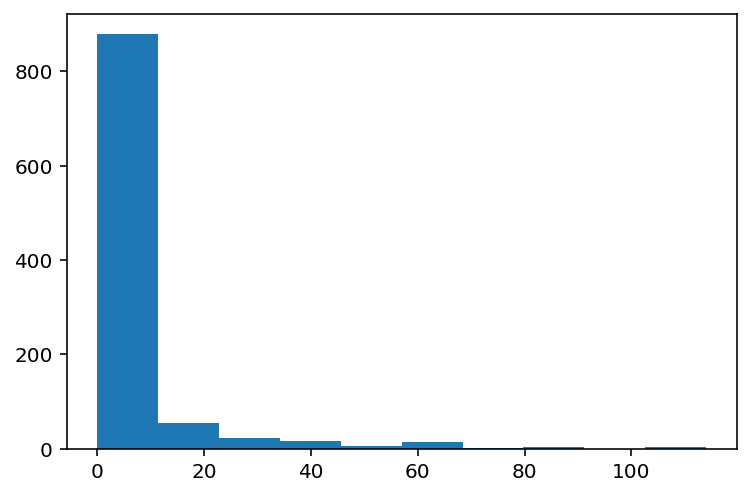

In [99]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.hist([len(i['accidents']) for i in new_intrs_list])

In [106]:
new_intrs_df.to_json("intersection-accidents.json")

ValueError: DataFrame index must be unique for orient='columns'.

In [110]:
new_intrs_df.iloc[8]

y                                                                        NaN
x                                                                        NaN
osmid                                                                    NaN
type                                                                     NaN
angles                                                                   NaN
roadways                                                                 NaN
highway                                                                  NaN
ref                                                                      NaN
geometry                        POINT (-8572607.119278837 4715199.126915545)
accidents                  [{'acc_id': 239440, 'dist': 147.87148024509398...
US_Accidents_June20.csv                                            A-3201949
Source                                                                  Bing
TMC                                                                      NaN

In [115]:
dc_intrs_df.head(25)

,y,x,osmid,type,angles,roadways,highway,ref,geometry
0,38.936663,-77.108254,281074,0,None,[],NaN,NaN,POINT (-77.10825 38.93666)
1,38.965100,-77.047143,29918140,5,None,[Beach Drive Northwest],NaN,NaN,POINT (-77.04714 38.96510)
2,38.884208,-77.003440,30066940,32,None,[],NaN,NaN,POINT (-77.00344 38.88421)
3,38.883326,-77.003434,30066941,32,None,[],NaN,NaN,POINT (-77.00343 38.88333)
4,38.883325,-77.002146,30066942,32,None,[],NaN,NaN,POINT (-77.00215 38.88332)
5,38.986196,-77.053154,49182343,0,None,[],NaN,NaN,POINT (-77.05315 38.98620)
6,38.951063,-77.098167,49184747,1,None,"[Chesapeake Street Northwest, Western Avenue N...",NaN,NaN,POINT (-77.09817 38.95106)
7,38.951499,-77.097608,49198976,1,None,[Western Avenue Northwest],NaN,NaN,POINT (-77.09761 38.95150)
8,38.953452,-77.009047,49715918,1,None,"[North Capitol Street Northwest, Hamilton Stre...",NaN,NaN,POINT (-77.00905 38.95345)
9,38.953308,-77.013516,49715932,1,None,"[Hamilton Street Northwest, 2nd Street Northwest]",NaN,NaN,POINT (-77.01352 38.95331)


In [116]:
dc_map.edges(49715918)

OutMultiEdgeDataView([(49715918, 7488432662), (49715918, 2591027951), (49715918, 2591027949)])

In [117]:
len(dc_map.edges(49715918))

3

In [119]:
edge_data = dc_map.get_edge_data(49715918, 7488432662)

In [130]:
edge_data

{0: {'osmid': 586326622,
  'lanes': '5',
  'name': 'North Capitol Street Northwest',
  'highway': 'primary',
  'oneway': False,
  'length': 71.353,
  'geometry': <shapely.geometry.linestring.LineString at 0x18fa0c400>}}

In [135]:
count = 0
if len(G.edges(node)) == 0:
    pass
for n1, n2 in G.edges(node):
    edge_data = G.get_edge_data(n1, n2)
    for data in edge_data.values():
        if not 'lanes' in data:
            continue
        else:
            try:
                count += int(data['lanes'])
            except ValueError:
                continue

print(count)

{'osmid': 586326622, 'lanes': '5', 'name': 'North Capitol Street Northwest', 'highway': 'primary', 'oneway': False, 'length': 43.044}
{'osmid': 6063129, 'oneway': True, 'name': 'Hamilton Street Northeast', 'highway': 'residential', 'length': 50.824999999999996, 'geometry': <shapely.geometry.linestring.LineString object at 0x18fa0c520>}
{'osmid': 586326622, 'lanes': '5', 'name': 'North Capitol Street Northwest', 'highway': 'primary', 'oneway': False, 'length': 71.353, 'geometry': <shapely.geometry.linestring.LineString object at 0x18fa0c400>}
10


In [142]:
with open('../data/dc_intersections.json', 'r') as infile:
    intrs = json.load(infile)

In [145]:
intrs

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-77.0471434, 38.9651003]},
   'properties': {'junction_type': 5,
    'num_legs': 3,
    'geometry_type': None,
    'geometry': None,
    'angle': 87.39999999999998,
    'lanes': 4,
    'oneway': 0.0,
    'longitude': -77.0471434,
    'latitude': 38.9651003,
    'nodeid': 'dqcjwtrupmjv',
    'names': ['Beach Drive Northwest'],
    'tooltip': '{\n  "junction_type": 5,\n  "num_legs": 3,\n  "geometry_type": null,\n  "geometry": null,\n  "angle": 87.39999999999998,\n  "lanes": 4,\n  "oneway": 0.0,\n  "longitude": -77.0471434,\n  "latitude": 38.9651003,\n  "nodeid": "dqcjwtrupmjv",\n  "names": [\n    "Beach Drive Northwest"\n  ]\n}'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-77.0034402, 38.8842085]},
   'properties': {'junction_type': 32,
    'num_legs': 4,
    'geometry_type': None,
    'geometry': None,
    'angle': 49.0,
    'lanes': 0,
    'onew